# Problem statement

Predict future sales amount for specific User and Product Code based on last month sales.

My approach is to try plug the data into a model: a **linear regression** and an **xgboost regression**. Encode categorical data as above.
Which error metric should I prefer?
How to choose the best feature (feature selection)? Use the pipeline. If not good, try look at the data and do univariate analysis.
Tune the model -> grid search

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew

import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import xgboost
from xgboost import plot_importance
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Feature engineering

## Read train and test sets

In [59]:
path = '/Users/dangloan/Documents/learning_analytics/project/'
df = pd.read_csv(path + '3_data/black_friday/train.csv')
df_test = pd.read_csv(path + '3_data/black_friday/test.csv')

In [60]:
# Remove outliers to make the model less sensitive to too large values. Thus, decrease RMSE
cutoff_purchase = np.percentile(df['Purchase'], 99.9)  # 99.9 percentile
df.ix[df['Purchase'] > cutoff_purchase, 'Purchase'] = cutoff_purchase

/Users/dangloan/miniconda3/envs/py/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
every_column_except_y = [col for col in df.columns if col not in []]
column_y = ['Purchase']

X = df[every_column_except_y]
y = df[column_y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Encode categorical features

In [62]:
# Cluster ProductID, UserID by Purchase mean and count
def cluster(df,train,test, variable):
    a = df.groupby(variable)['Purchase'].agg({'count','mean'}).reset_index()
    count = variable + '_count'
    mean = variable + '_mean'
    cluster = variable + '_cluster'
    a.columns =[variable,count,mean]

    scaler = StandardScaler()
    b = scaler.fit_transform(a[[count,mean]])

    kmeans = KMeans(n_clusters=5)  
    kmeans.fit(b)

    b_df = pd.DataFrame(b)

    b_df['cluster'] = kmeans.labels_
    
    arr1 = np.array(kmeans.cluster_centers_)
    arr2 = np.array([0,1,2,3,4]).reshape((5,1))
    centroids1 = np.concatenate((arr1,arr2), axis=1)
    df_cen = pd.DataFrame(centroids1, columns=['count_centr','mean_centr','cluster']) 
    df_cen['cluster']=df_cen['cluster'].astype(int)
    b_df = pd.merge(b_df,df_cen,on='cluster', how='left')
    b_df = b_df[['count_centr','mean_centr']]
    
    
    
    b_df = pd.concat([b_df.reset_index(drop=True), 
                      a[[variable]].reset_index(drop=True)],
                     axis=1,ignore_index= True)

    b_df.columns = [variable + '_count_centr', variable + '_mean_centr', variable]

    train_result = train.merge(b_df,
                           on=variable, how='left')
    test_result = test.merge(b_df,
                           on=variable, how='left')
    return train_result, test_result

X_train1, X_test1 = cluster(X_train,X_train,X_test,'Product_ID')
X_train1, X_test1 = cluster(X_train,X_train1,X_test1,'User_ID')

In [63]:
def clean(df_stat, df):
    # Compute counts for high cardinality artributes
    Occ_stats = df_stat.groupby('Occupation')['Purchase'].agg(['count','mean','std']).reset_index()
    Occ_stats.columns = ['Occupation','Occ_count','Occ_mean','Occ_std']

    Cat1_stats = df_stat.groupby('Product_Category_1')['Purchase'].agg(['count','mean','std']).reset_index()
    Cat1_stats.columns = ['Product_Category_1','Cat1_count','Cat1_mean','Cat1_std']

    Cat2_stats = df_stat.groupby('Product_Category_2')['Purchase'].agg(['count','mean','std']).reset_index()
    Cat2_stats.columns = ['Product_Category_2','Cat2_count','Cat2_mean','Cat2_std']

    Cat3_stats = df_stat.groupby('Product_Category_3')['Purchase'].agg(['count','mean','std']).reset_index()
    Cat3_stats.columns = ['Product_Category_3','Cat3_count','Cat3_mean','Cat3_std']
    
    ProdID_stats = df_stat.groupby('Product_ID')['Purchase'].agg(['count','mean','std']).reset_index()
    ProdID_stats.columns = ['Product_ID', 'ProdID_count','ProdID_mean','ProdID_std']
    
    UserID_stats = df_stat.groupby('User_ID')['Purchase'].agg(['count','mean','std']).reset_index()
    UserID_stats.columns = ['User_ID', 'UserID_count','UserID_mean','UserID_std']

    df1 = df.merge(ProdID_stats,on='Product_ID', how='left')\
                    .merge(UserID_stats,on='User_ID', how='left')\
                    .merge(Occ_stats,on='Occupation', how='left')\
                    .merge(Cat1_stats,on='Product_Category_1', how='left')\
                    .merge(Cat2_stats,on='Product_Category_2', how='left')\
                    .merge(Cat3_stats,on='Product_Category_3', how='left')


    # Fill missing data
    df1.fillna(0,inplace=True)
    
    
    df1['Stay_In_Current_City_Years'] = df1['Stay_In_Current_City_Years'].str.strip("+")
    df1['Stay_In_Current_City_Years'] = pd.to_numeric(df1['Stay_In_Current_City_Years'])
    df1.loc[df1['Stay_In_Current_City_Years'] == 4, "Stay_In_Current_City_Years"] = 10

    
    # Transform age
    age_map = { '0-17' : 17, 
                  '18-25' : 25, 
                  '26-35' : 35, 
                  '36-45' : 45, 
                  '46-50' : 50,
                  '51-55' : 55,
                  '55+' : 70}

    df1['Age_mapped'] = df1['Age'].map(age_map)
    
    df1 = df1.drop(['Purchase','Age','Occupation','Product_Category_1',
              'Product_Category_2','Product_Category_3',
              'Product_ID','User_ID'], axis=1)

    return df1

X_train1 = clean(X_train,X_train1)
X_test1 = clean(X_train,X_test1)

In [64]:
# Use one hot encoding for Gender and City_Category features
onehot_cols = ['Gender','City_Category']
ce_one_hot = ce.OneHotEncoder(cols = onehot_cols)
X_train1 = ce_one_hot.fit_transform(X_train1)
X_test1 = ce_one_hot.transform(X_test1)

In [65]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

In [66]:
X_train1.head()

,Gender_1,Gender_2,City_Category_1,City_Category_2,City_Category_3,Stay_In_Current_City_Years,Marital_Status,Product_ID_count_centr,Product_ID_mean_centr,User_ID_count_centr,User_ID_mean_centr,ProdID_count,ProdID_mean,ProdID_std,UserID_count,UserID_mean,UserID_std,Occ_count,Occ_mean,Occ_std,Cat1_count,Cat1_mean,Cat1_std,Cat2_count,Cat2_mean,Cat2_std,Cat3_count,Cat3_mean,Cat3_std,Age_mapped
0,1,0,1,0,0,3,1,1.519381,-0.097964,-0.235086,1.108322,154,11426.487013,4122.743918,251,8250.334661,4424.608157,47194,9434.817816,5094.620553,112330,13610.155684,4288.311900,30274.0,10352.674870,5593.418510,0.0,0.000000,0.000000,55
1,1,0,0,1,0,10,0,-0.201047,1.111439,0.204076,-0.375442,516,6501.972868,1915.160776,58,11073.827586,5068.334870,25020,9797.216667,5136.888504,120631,6236.131417,1910.299020,0.0,0.000000,0.000000,0.0,0.000000,0.000000,25
2,1,0,1,0,0,1,0,-0.157860,-0.399292,-0.562107,3.493411,29,6124.655172,2358.975478,370,9340.305405,4911.578884,9807,9343.996941,4996.781994,91126,7499.600641,2013.649156,43897.0,7092.815432,3235.732789,13269.0,11761.739166,5081.664057,35
3,1,0,1,0,0,2,0,1.197134,3.317994,0.204076,-0.375442,652,8107.062883,2108.182733,100,10531.220000,5011.731054,57816,9229.586170,5054.295142,91126,7499.600641,2013.649156,0.0,0.000000,0.000000,0.0,0.000000,0.000000,25
4,1,0,1,0,0,1,0,1.519381,-0.097964,0.204076,-0.375442,124,13225.483871,3291.215263,83,10451.783133,5194.145022,57816,9229.586170,5054.295142,112330,13610.155684,4288.311900,51308.0,10260.907246,5309.731382,0.0,0.000000,0.000000,25


# Modeling

## Linear Regression Model

In [67]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


# Predict
predictions = lr_model.predict(X_test_scaled)

#Evaluate
print ('Training error')
print (lr_model.score(X_train_scaled, y_train))

print ('Test error')
print (lr_model.score(X_test_scaled, y_test))

# from sklearn.metrics import mean_squared_error
print("R_squared")
print(r2_score(predictions, y_test))

mse = mean_squared_error(predictions,y_test)
print('Mean_squared_error')
print(np.sqrt(mse))

Training error
0.7441741157752226
Test error
0.7312719589710124
R_squared
0.6349140890326164
Mean_squared_error
2598.350392940454


## XGBoost Training

In [11]:
model = xgboost.XGBRegressor(colsample_bytree=0.8,
                 gamma=0,                 
                 learning_rate=0.15,
                 max_depth=3,
                 min_child_weight=1,
                 n_estimators=15000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

model.fit(X_train_scaled,y_train)

# Predict
predictions = model.predict(X_test_scaled)

#Evaluate
print (model.score(X_train_scaled, y_train))
print (model.score(X_test_scaled, y_test))

# from sklearn.metrics import mean_squared_error
print(r2_score(predictions, y_test))
mse = mean_squared_error(predictions,y_test)
print(np.sqrt(mse))

[09:17:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8027069445574542
0.7512935723154163
0.6780725440264868
2499.6817982370603


### Tune parameters

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000,
                                                         gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                         nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_scaled,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test2 = {
 'n_estimators':range(100,20000,200)
}
gsearch1 = GridSearchCV(estimator = xgboost.XGBRegressor(learning_rate =0.1,max_depth=3, min_child_weight=1,
                                                         gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                         nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_scaled,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

### Predict

In [68]:
# Cluster ProductID, UserID by Purchase mean and count
def cluster(df,train, test, variable):
    a = df.groupby(variable)['Purchase'].agg({'count','mean'}).reset_index()
    count = variable + '_count'
    mean = variable + '_mean'
    cluster = variable + '_cluster'
    a.columns =[variable,count,mean]

    scaler = StandardScaler()
    b = scaler.fit_transform(a[[count,mean]])

    kmeans = KMeans(n_clusters=5)  
    kmeans.fit(b)

    b_df = pd.DataFrame(b)

    b_df['cluster'] = kmeans.labels_
    arr1 = np.array(kmeans.cluster_centers_)
    arr2 = np.array([0,1,2,3,4]).reshape((5,1))
    centroids1 = np.concatenate((arr1,arr2), axis=1)
    df_cen = pd.DataFrame(centroids1, columns=['count_centr','mean_centr','cluster']) 
    df_cen['cluster']=df_cen['cluster'].astype(int)
    b_df = pd.merge(b_df,df_cen,on='cluster', how='left')
    b_df = b_df[['count_centr','mean_centr']]
    
    
    
    b_df = pd.concat([b_df.reset_index(drop=True), 
                      a[[variable]].reset_index(drop=True)],
                     axis=1,ignore_index= True)

    b_df.columns = [variable + '_count_centr', variable + '_mean_centr', variable]

    train_result = train.merge(b_df,
                           on=variable, how='left')
    test_result = test.merge(b_df,
                           on=variable, how='left')
    return train_result, test_result

X_train1, X_test1 = cluster(df,df,df_test,'Product_ID')
X_train1, X_test1 = cluster(df,X_train1,X_test1,'User_ID')

In [69]:
def clean(df_stat, df):
    #Compute counts for high cardinality artributes
    Occ_stats = df_stat.groupby('Occupation')['Purchase'].agg(['count','mean','std']).reset_index()
    Occ_stats.columns = ['Occupation','Occ_count','Occ_mean','Occ_std']

    Cat1_stats = df_stat.groupby('Product_Category_1')['Purchase'].agg(['count','mean','std']).reset_index()
    Cat1_stats.columns = ['Product_Category_1','Cat1_count','Cat1_mean','Cat1_std']

    Cat2_stats = df_stat.groupby('Product_Category_2')['Purchase'].agg(['count','mean','std']).reset_index()
    Cat2_stats.columns = ['Product_Category_2','Cat2_count','Cat2_mean','Cat2_std']

    Cat3_stats = df_stat.groupby('Product_Category_3')['Purchase'].agg(['count','mean','std']).reset_index()
    Cat3_stats.columns = ['Product_Category_3','Cat3_count','Cat3_mean','Cat3_std']
    
    ProdID_stats = df_stat.groupby('Product_ID')['Purchase'].agg(['count','mean','std']).reset_index()
    ProdID_stats.columns = ['Product_ID', 'ProdID_count','ProdID_mean','ProdID_std']
    
    UserID_stats = df_stat.groupby('User_ID')['Purchase'].agg(['count','mean','std']).reset_index()
    UserID_stats.columns = ['User_ID', 'UserID_count','UserID_mean','UserID_std']

    df1 = df.merge(ProdID_stats,on='Product_ID', how='left')\
                    .merge(UserID_stats,on='User_ID', how='left')\
                    .merge(Occ_stats,on='Occupation', how='left')\
                    .merge(Cat1_stats,on='Product_Category_1', how='left')\
                    .merge(Cat2_stats,on='Product_Category_2', how='left')\
                    .merge(Cat3_stats,on='Product_Category_3', how='left')


#    #Taking care of missing data
#     cols = ['Occ_count','Cat1_count',
#             'Cat2_count','Cat3_count']
#     from sklearn.preprocessing import Imputer
#     imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
#     imputer = imputer.fit(df1[cols])
#     df1[cols] = imputer.transform(df1[cols])
#     df1[cols] = df1[cols].fillna(0)
    df1.fillna(0,inplace=True)
    
    
    df1['Stay_In_Current_City_Years'] = df1['Stay_In_Current_City_Years'].str.strip("+")
    df1['Stay_In_Current_City_Years'] = pd.to_numeric(df1['Stay_In_Current_City_Years'])
    df1.loc[df1['Stay_In_Current_City_Years'] == 4, "Stay_In_Current_City_Years"] = 10

    
    #transform age
    age_map = { '0-17' : 17, 
                  '18-25' : 25, 
                  '26-35' : 35, 
                  '36-45' : 45, 
                  '46-50' : 50,
                  '51-55' : 55,
                  '55+' : 70}

    df1['Age_mapped'] = df1['Age'].map(age_map)
    
    df1 = df1.drop(['Age','Occupation','Product_Category_1',
              'Product_Category_2','Product_Category_3',
            'Product_ID','User_ID'], axis=1)

    return df1

# X_train1 = clean(df,X_train1)
X_test1 = clean(df,X_test1)

In [70]:
# One hot encode cat features
onehot_cols = ['Gender','City_Category']
X_test1 = ce_one_hot.transform(X_test1)

In [71]:
#Scale data
X_test_scaled = scaler.transform(X_test1)

In [72]:
predictions = model.predict(X_test_scaled)

In [73]:
df_test['Purchase'] = predictions

In [74]:
sample = df_test[['User_ID','Product_ID','Purchase']]

In [75]:
sample.to_csv('/Users/dangloan/Documents/learning_analytics/project/3_data/black_friday/sample9.csv', index=False)

In [76]:
# Calculate feature importances
importances = model.feature_importances_
# importances = model1.get_booster().get_score(importance_type='weight')

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_test1.columns[i] for i in indices]


a=list(zip(names,importances[indices]))
a

[('Cat1_mean', 0.293073),
 ('ProdID_mean', 0.2929595),
 ('Product_ID_count_centr', 0.09591798),
 ('Cat1_count', 0.05482998),
 ('Cat1_std', 0.024675217),
 ('UserID_mean', 0.017758671),
 ('Gender_1', 0.014062934),
 ('User_ID_count_centr', 0.012779523),
 ('Gender_2', 0.011633198),
 ('User_ID_mean_centr', 0.011271265),
 ('UserID_std', 0.010567753),
 ('City_Category_2', 0.010339253),
 ('UserID_count', 0.00994507),
 ('Age_mapped', 0.009909583),
 ('City_Category_3', 0.009903284),
 ('Occ_mean', 0.009202369),
 ('Marital_Status', 0.008930722),
 ('Product_ID_mean_centr', 0.00889683),
 ('Occ_std', 0.008837526),
 ('Stay_In_Current_City_Years', 0.008676366),
 ('Occ_count', 0.008497623),
 ('City_Category_1', 0.008336751),
 ('ProdID_std', 0.008129911),
 ('Cat2_count', 0.007825902),
 ('ProdID_count', 0.007630702),
 ('Cat2_std', 0.0075388607),
 ('Cat2_mean', 0.0074719917),
 ('Cat3_count', 0.0071252426),
 ('Cat3_mean', 0.0066638463),
 ('Cat3_std', 0.0066091046)]

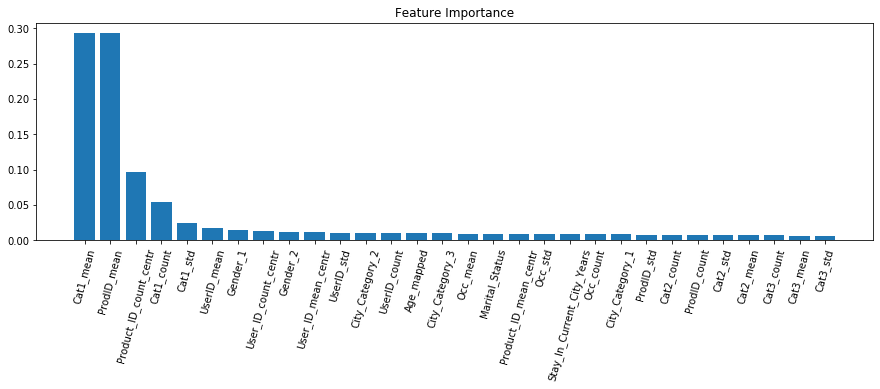

In [77]:
# Create plot
plt.figure(figsize=(15,4))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_test1.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_test1.shape[1]), names, rotation=75)

# Show plot
plt.show()